# Charactor-level RNN for shakespear

    modified from https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

import time
import math


In [3]:
# parameter
keywords_dict ={}
keywords_dict['hidden_size'] = 100
keywords_dict['seq_length'] = 25
keywords_dict['learning_rate'] = 0.001

data = open('data/shakespeare_input.txt', 'r').read() # should be simple plain text file
data = data[:1000000]
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
keywords_dict['data_size'] = data_size
keywords_dict['all_letters'] = ''.join(sorted(chars))
keywords_dict['n_letters'] = len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }


data has 1000000 characters, 65 unique.


In [4]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [8]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.W_xh = nn.Linear(input_size, hidden_size)
        self.W_hh = nn.Linear(hidden_size, hidden_size)
        self.W_hy = nn.Linear(hidden_size, output_size)
        self.act = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, _input, hidden):
        hidden = self.W_xh(_input).add(self.W_hh(hidden))
        hidden = self.act(hidden)
        output = self.W_hy(hidden)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    


In [6]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line, keywords_dict):
    all_letters = keywords_dict['all_letters']
    n_letters = keywords_dict['n_letters']
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
#         print(letter)
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line, keywords_dict):
    all_letters = keywords_dict['all_letters']
    n_letters = keywords_dict['n_letters']
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def createTrainingExample(line, keywords_dict):
#     category, line = randomTrainingPair()
#     line = randomChoice(keywords_dict['name_vector'])
#     category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line[:-1], keywords_dict)
#     print(input_line_tensor)
    target_line_tensor = targetTensor(line[1:], keywords_dict)
#     print(target_line_tensor)

#     return category_tensor, input_line_tensor, target_line_tensor
    return input_line_tensor, target_line_tensor

In [7]:
def running(rnn, optimizer, keywords_dict):
    seq_length = keywords_dict['seq_length']

    print_every = 5000
    plot_every = 500
    start = time.time()
    
    all_losses = []
    total_loss = 0 # Reset every plot_every iters

    _iter, p = 0, 0
    epoch = 0
    
    loss_fun = nn.NLLLoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

    while epoch < 10:
        if p + seq_length +1 >= len(data):
            epoch +=1
            p = 0
        # Generate input and target
        input_line_tensor, target_line_tensor = createTrainingExample(data[p:p+seq_length+1], keywords_dict)
        target_line_tensor.unsqueeze_(-1)
        # Initiation
        hidden = rnn.initHidden()
        rnn.zero_grad()
        loss = 0
        # Training
        for i in range(input_line_tensor.size(0)):
            output, hidden = rnn(input_line_tensor[i], hidden)
            
            l = loss_fun(output, target_line_tensor[i])
            loss += l
        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        p += seq_length # move data pointer
        _iter += 1 # iteration counter

        total_loss += loss

        if _iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), _iter, _iter / (keywords_dict['data_size']/keywords_dict['seq_length']) * 100, loss))

        if _iter % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
    return rnn, optimizer, all_losses
rnn2 = nn.RNN(input_size=68, 
              hidden_size=512, 
              num_layers=3, 
              nonlinearity='tanh', 
              dropout=0.05)
rnn = RNN(keywords_dict['n_letters'], keywords_dict['hidden_size'], keywords_dict['n_letters'])
optimizer = torch.optim.Adam(rnn.parameters(), lr=keywords_dict['learning_rate'])
rnn, optimizer, all_losses = running(rnn, optimizer, keywords_dict)

0m 40s (5000 12%) 74.8948
1m 22s (10000 25%) 72.3660
2m 7s (15000 37%) 59.4150
2m 55s (20000 50%) 65.2377
3m 38s (25000 62%) 75.3467
4m 20s (30000 75%) 49.8004
5m 1s (35000 87%) 79.1846
5m 42s (40000 100%) 82.5533
6m 26s (45000 112%) 66.5690
7m 10s (50000 125%) 62.3192
7m 54s (55000 137%) 75.7857
8m 35s (60000 150%) 59.6011
9m 18s (65000 162%) 71.8163
10m 2s (70000 175%) 72.1234
10m 46s (75000 187%) 45.4798
11m 28s (80000 200%) 58.9451
12m 10s (85000 212%) 72.5999
12m 52s (90000 225%) 60.3428
13m 35s (95000 237%) 86.8605
14m 18s (100000 250%) 61.7535
14m 59s (105000 262%) 68.8575
15m 40s (110000 275%) 78.8668
16m 22s (115000 287%) 46.6769
17m 3s (120000 300%) 78.2617
17m 44s (125000 312%) 72.3784
18m 25s (130000 325%) 76.7444
19m 6s (135000 337%) 77.3742
19m 48s (140000 350%) 55.7929
20m 30s (145000 362%) 70.3766
21m 13s (150000 375%) 59.2016
21m 58s (155000 387%) 61.1373
22m 38s (160000 400%) 69.8092
23m 19s (165000 412%) 74.8638
24m 1s (170000 425%) 68.0648
24m 41s (175000 437%) 72.2

In [18]:
# rnn, all_losses = running(rnn, keywords_dict)

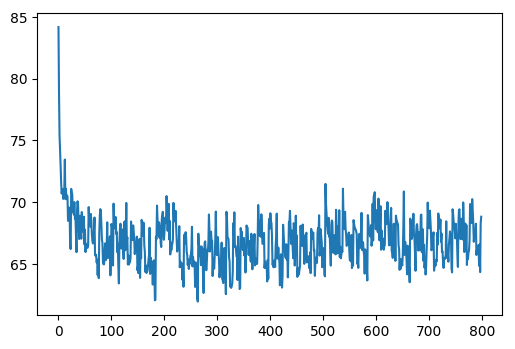

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.figure()
plt.plot(all_losses)

In [10]:
import random
def generate_letter(dist):
        x = random.random()
        for c,v in enumerate(dist):
            x = x - v
            if x <= 0: return c
import numpy as np
# Sample from a category and starting letter
def sample(rnn, keywords_dict, start_letter='a', max_length=25):
    with torch.no_grad():  # no need to track history in sampling
#         category_tensor = categoryTensor(category)
        _input = inputTensor(start_letter, keywords_dict)
        hidden = rnn.initHidden()

        outputs = start_letter

        for i in range(keywords_dict['seq_length']):
            output, hidden = rnn(_input[0], hidden)
#             topv, topi = output.topk(1)
            dist = np.exp(np.array(output)[0])
#             print(dist)
#             topi = topi[0][0]
            letter = keywords_dict['all_letters'][generate_letter(dist)]
#             letter = keywords_dict['all_letters'][topi]

            outputs += letter
            _input = inputTensor(letter, keywords_dict)

        return outputs
s = sample(rnn, keywords_dict)
print(s)

adhse i oloztrAcdr rzEz3:M


In [8]:
x = torch.tensor([1, 2, 3, 4])

In [9]:
x.unsqueeze_(-1)

tensor([[1],
        [2],
        [3],
        [4]])

In [ ]:
nn.RNN()